#***1.1 Deep vs Shallow:***
single-input, single-output non-linear functions trained on MNIST or CIFAR-10.

Chose to use CNNs.

In [1]:
# pip install torch

In [2]:
# pip install torchvision

In [3]:
import torch
import os
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [4]:
project_name = "01-cifar10-cnn"

In [5]:
# download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, ".")

Using downloaded and verified file: ./cifar10.tgz


In [6]:
# extract from archive into train and test dataset (if this is the first time you're running this program, uncomment the below section)
# with tarfile.open("./cifar10.tgz", "r:gz") as tar:
#   tar.extractall(path="./data")

In [7]:
data_dir = "./data/cifar10"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['frog', 'bird', 'airplane', 'dog', 'deer', 'cat', 'automobile', 'truck', 'ship', 'horse']


In [8]:
# transform the images into tensors
dataset = ImageFolder(data_dir+"/train", transform=ToTensor())

In [9]:
img, label = dataset[0]

# prints 3 32x32 matrices
print(img.shape, label)

# list of classes is stored in the .classes property
print(dataset.classes)

torch.Size([3, 32, 32]) 0
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Changing tensor dimensions to be viewable in Matplotlib.

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 4

In [11]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [12]:
# divides data into batches
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

# **Creating Networks**

effect of conv2d layer on width and height:
W = input width/input height
F = Filter width/filter height
P = Padding
S = Stride
(W-F +2P)/S+1

effect of pooling layer:
W/2

flattening dimensions need to be equal to:
number_of_filters*output_height*output_width

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
from torch.nn.modules import Softmax
from torch.nn.modules.activation import ReLU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*12*12, 120)
    self.fc2 = nn.Linear(120, 84)
    self.Dropout = nn.Dropout(0.25)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.Dropout(x)
    x = x.view(-1, 16*12*12)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model_one = ConvNet().to(device)
num_params = sum(p.numel() for p in model_one.parameters())
print(num_params)

290486


In [50]:
# NOTE: check your values!! just wasted a bunch of time.
class ConvNet_two(nn.Module):
  def __init__(self):
    super(ConvNet_two, self).__init__()
    self.conv1 = nn.Conv2d(3,15,3)
    self.conv2 = nn.Conv2d(15,32,3)
    self.conv3 = nn.Conv2d(32,42,3)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(42*6*6, 170)
    self.fc2 = nn.Linear(170, 91)
    self.Dropout = nn.Dropout(0.5)
    self.fc3 = nn.Linear(91, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.Dropout(x)
    x = x.view(-1, 42*6*6)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model_two = ConvNet_two().to(device)
num_params = sum(p.numel() for p in model_two.parameters())
print(num_params)

290601


In [30]:
class ConvNet_three(nn.Module):
  def __init__(self):
    super(ConvNet_three, self).__init__()
    self.conv1 = nn.Conv2d(3,64,3)
    self.conv2 = nn.Conv2d(64,128,3)
    self.conv3 = nn.Conv2d(128,256,3)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(256*6*6, 120)
    self.fc2 = nn.Linear(120, 84)
    self.Dropout = nn.Dropout(0.5)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.Dropout(x)
    x = x.view(-1, 256*6*6)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model_three = ConvNet_three().to(device)
num_params = sum(p.numel() for p in model_three.parameters())
print(num_params)

1487870


# **Creating functions to train the networks.**
CollectWeights class: is responsible for gathering all of the weights of the model in each epic

fit_model function: is responsible for training the model.

evaulate_model: is responsible for calculating the accuracy of the model

gradient_norm function: is responsible for recording the gradient norm and the loss during training

In [17]:
# collect weights function
class CollectWeights:
  def __init__(self, model):
    self.model = model
    self.epoch_weights = []

  def end_of_epoch(self, epoch, logs={}):
    state_dict = self.model.state_dict()
    self.epoch_weights.append(state_dict)

In [18]:
# fit model function
n_total_steps = len(train_dl)
num_epochs = 10

def fit_model(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=.001)
  callback = CollectWeights(model)
  model_list = []

  # begin training loop
  for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_dl):
      images = images.to(device)
      labels = labels.to(device)

      # forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i % len(train_dl) == 0):
        print(f'MODEL: Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # record gradient norm
        grad_all = 0.0

        for p in model.parameters():
          grad = 0.0
          if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
          grad_all += grad

        grad_norm = grad_all ** 0.5
        
        # collects loss values
        model_list.append(loss.item())
        
        # collect weights
        callback.end_of_epoch(epoch)

  print(f'MODEL: Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
  #collect parameters of model at every epoch
  params = model.state_dict()
  param_total = 0
  for name, param in params.items():
    print(f'{name}: {param.shape}')
  return model_list, callback.epoch_weights


In [19]:
# evaluate model accuracy

model_one_accuracy = []
model_two_accuracy = []
model_three_accuracy = []

def evaluate_model (model, model_list):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images,labels in val_dl:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      accuract_value = 100*correct/total
      model_list.append(accuract_value)
      i = 0
      
    print(f"Accuract of the model on the test images: {100*correct/total}%")

# **Model Training and Evaluation**
Each cell below includes the model's training and evaluation functions.

In [20]:
model_one_loss = []
model_one_weights = []

model_one_loss, model_one_weights = fit_model(model_one)
print("Model [1] Loss: ", model_one_loss[-1])
evaluate_model(model_one, model_one_accuracy)

MODEL: Epoch [1/10], Step [1/11250], Loss: 2.2782
MODEL: Epoch [2/10], Step [1/11250], Loss: 2.2963
MODEL: Epoch [3/10], Step [1/11250], Loss: 2.5770
MODEL: Epoch [4/10], Step [1/11250], Loss: 2.2544
MODEL: Epoch [5/10], Step [1/11250], Loss: 1.7665
MODEL: Epoch [6/10], Step [1/11250], Loss: 1.9311
MODEL: Epoch [7/10], Step [1/11250], Loss: 1.5431
MODEL: Epoch [8/10], Step [1/11250], Loss: 1.9212
MODEL: Epoch [9/10], Step [1/11250], Loss: 1.6548
MODEL: Epoch [10/10], Step [1/11250], Loss: 2.0213
MODEL: Epoch [10/10], Step [11250/11250], Loss: 1.5749
conv1.weight: torch.Size([6, 3, 5, 5])
conv1.bias: torch.Size([6])
conv2.weight: torch.Size([16, 6, 5, 5])
conv2.bias: torch.Size([16])
fc1.weight: torch.Size([120, 2304])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])
Model [1] Loss:  2.0212502479553223
Accuract of the model on the test images: 53.96%


In [21]:
model_two_loss = []
model_two_weights = []

model_two_loss, model_two_weights = fit_model(model_two)
print("Model [2] Loss: ", model_two_loss[-1])
evaluate_model(model_two, model_two_accuracy)

MODEL: Epoch [1/10], Step [1/11250], Loss: 2.3546
MODEL: Epoch [2/10], Step [1/11250], Loss: 2.3050
MODEL: Epoch [3/10], Step [1/11250], Loss: 2.3090
MODEL: Epoch [4/10], Step [1/11250], Loss: 2.3107
MODEL: Epoch [5/10], Step [1/11250], Loss: 2.5652
MODEL: Epoch [6/10], Step [1/11250], Loss: 2.5742
MODEL: Epoch [7/10], Step [1/11250], Loss: 1.7312
MODEL: Epoch [8/10], Step [1/11250], Loss: 1.5554
MODEL: Epoch [9/10], Step [1/11250], Loss: 0.6338
MODEL: Epoch [10/10], Step [1/11250], Loss: 0.9067
MODEL: Epoch [10/10], Step [11250/11250], Loss: 1.0853
conv1.weight: torch.Size([12, 3, 3, 3])
conv1.bias: torch.Size([12])
conv2.weight: torch.Size([18, 12, 3, 3])
conv2.bias: torch.Size([18])
conv3.weight: torch.Size([26, 18, 3, 3])
conv3.bias: torch.Size([26])
fc1.weight: torch.Size([100, 936])
fc1.bias: torch.Size([100])
fc2.weight: torch.Size([84, 100])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])
Model [2] Loss:  0.9066630005836487
Accuract of the

In [22]:
model_three_loss = []
model_three_weights = []

model_three_loss, model_three_weights = fit_model(model_three)
print("Model [3] Loss: ", model_three_loss[-1])
evaluate_model(model_three, model_three_accuracy)

MODEL: Epoch [1/10], Step [1/11250], Loss: 2.2715
MODEL: Epoch [2/10], Step [1/11250], Loss: 2.1748
MODEL: Epoch [3/10], Step [1/11250], Loss: 1.1748
MODEL: Epoch [4/10], Step [1/11250], Loss: 1.5331
MODEL: Epoch [5/10], Step [1/11250], Loss: 1.7338
MODEL: Epoch [6/10], Step [1/11250], Loss: 1.3793
MODEL: Epoch [7/10], Step [1/11250], Loss: 0.7346
MODEL: Epoch [8/10], Step [1/11250], Loss: 1.5724
MODEL: Epoch [9/10], Step [1/11250], Loss: 1.0842
MODEL: Epoch [10/10], Step [1/11250], Loss: 1.3314
MODEL: Epoch [10/10], Step [11250/11250], Loss: 1.2769
conv1.weight: torch.Size([64, 3, 3, 3])
conv1.bias: torch.Size([64])
conv2.weight: torch.Size([128, 64, 3, 3])
conv2.bias: torch.Size([128])
conv3.weight: torch.Size([256, 128, 3, 3])
conv3.bias: torch.Size([256])
fc1.weight: torch.Size([120, 9216])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])
Model [3] Loss:  1.3313677310943604
Accuract 

# **Visualizing Training Loss and Training Accuracy:**

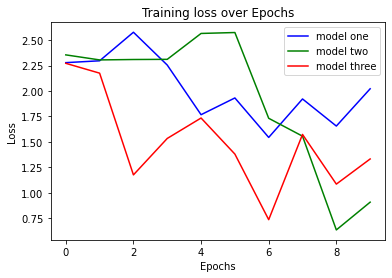

In [23]:
plt.plot(model_one_loss, color="blue", label="model one")
plt.plot(model_two_loss, color="green", label="model two")
plt.plot(model_three_loss, color="red", label="model three")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss over Epochs')
plt.legend()
plt.show()

The training loss is not that surprising as it should take time for model_three's more complex architecture and size to eventually outperform model_two's more shallow parameter base. Model_one being so much less in effective in it's loss might display that model_two could be overfitting considering they are somewhat similar and model_two has far less parameters per layer. This would be surprising considering there is a .5 dropset attached to model_two. 

Besides this, everything looks normal to me. I would imagine that after several more iterations (into the tens and reaching 100 epochs) we would most likely start to see model_three outperform the rest of the models as it has the most parameters and deepest network for obtaining more generalizations about the dataset without compromising its filters.

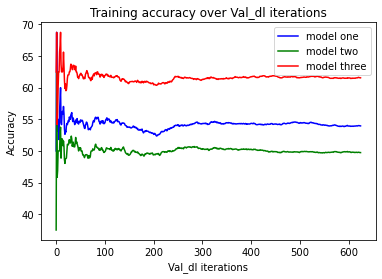

In [24]:
plt.plot(model_one_accuracy, color="blue", label="model one")
plt.plot(model_two_accuracy, color="green", label="model two")
plt.plot(model_three_accuracy, color="red", label="model three")

plt.xlabel('Val_dl iterations')
plt.ylabel('Accuracy')
plt.title('Training accuracy over Val_dl iterations')
plt.legend()
plt.show()

Now that we see the results of accuracy of all three models on the validation set, I would say I am not surprised at all by the results. The more trivial architecture of model_two shows that it really was overfitting and plateuas rather quickly. Meanwhile I did not expect model_three to plateua as such, possibly more training would allow for it to obtain better results as it probably didn't refine it's filters all that well. Another interesting idea would be to change the batch_size to see how that interacts with the models. Model_one performing as well as it did with a relatively small parameter limit and limited training despite being identical in param amount to model_two just shows that shallow models can beat deeper models and that the parameters per layer play a large part in being accurate as it has almost a 5% increase over model_two.